In [1]:
import os  # noqa
import sys  # noqa

proj_root = os.path.dirname(os.getcwd())
sys.path.append(proj_root)

OBJ_NAME = "mustard_bottle"
VIDEO_NAME = "mustard0"
SUPPORT_GRID = None
CROP = True
BLACK_BACKGROUND = True
MASK_THRESHOLD = 0.5
USE_GT_AS_BASE_POSE = True
NUM_INTERPOLATION_STEPS = 15 if not USE_GT_AS_BASE_POSE else 0
OFFLINE = True
OFFLINE_LIMIT = 500

COTRACKER_STEP = 8
COTRACKER_MODEL_RESOLUTION = (384, 512)

video_dir = os.path.join(proj_root, "data", "inputs", VIDEO_NAME)
canonical_points_path = os.path.join(video_dir, "canonical_3d_points.npy")
query_points_path = os.path.join(video_dir, "query_points.npy")
tracker_result_video = os.path.join(video_dir, "tracker_result.mp4")
cam_K_dir = os.path.join(video_dir, "cam_K.txt")
poses_dir = os.path.join(video_dir, "annotated_poses")
video_gt_mask_dir = os.path.join(video_dir, "gt_mask")
video_mask_dir = os.path.join(video_dir, "masks")
video_rgb_dir = os.path.join(video_dir, "rgb")
video_img_dir = os.path.join(video_dir, "img")
video_gt_coords_dir = os.path.join(video_dir, "gt_coords.npy")
video_gt_visibility_dir = os.path.join(video_dir, "gt_visibility.npy")
obj_dir = os.path.join(proj_root, "data", "objects", OBJ_NAME)
obj_path = os.path.join(obj_dir, "textured_simple.obj")
ply_path = os.path.join(obj_dir, "textured.ply")
texture_path = os.path.join(obj_dir, "texture_map.png")

assert CROP != (
    SUPPORT_GRID is not None
), "SUPPORT_GRID must be set if BLACK_BACKGROUND is False"

/home/joao/miniconda3/envs/gspose/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(


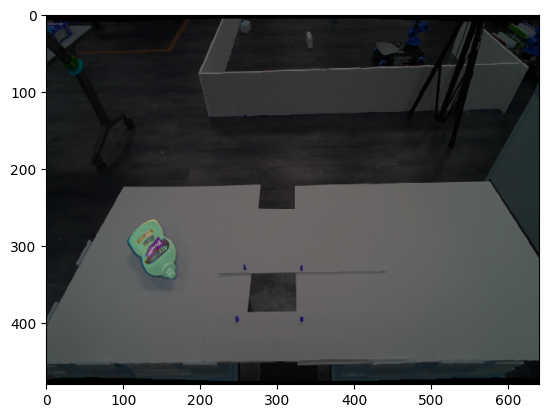

In [2]:
from posingpixels.utils.offscreen_renderer import ModelRendererOffscreen
import cv2
import numpy as np
import trimesh
import matplotlib.pyplot as plt

from posingpixels.utils.meshes import get_diameter_from_mesh
from posingpixels.alignment import get_safe_query_points
import mediapy
from scipy.spatial.transform import Rotation as R
from scipy.spatial.transform import Slerp
from posingpixels.sam import segment
from pathlib import Path
import torch
from concurrent.futures import ThreadPoolExecutor
from cotracker.utils.visualizer import Visualizer
from posingpixels.cotracker import get_online_cotracker_predictions
from typing import Tuple
import torch.nn.functional as F

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


K = np.loadtxt(cam_K_dir).reshape(3, 3)
rgb = cv2.imread(
    os.path.join(video_rgb_dir, "1581120424100262102.png"), cv2.IMREAD_COLOR
)
start_pose = np.loadtxt(os.path.join(poses_dir, "0000000.txt")).reshape(4, 4)
H, W = rgb.shape[:2]
model_renderer = ModelRendererOffscreen(K, H, W)
mesh: trimesh.Trimesh = trimesh.load_mesh(obj_path)
rgb_render, depth_render = model_renderer.render(mesh, ob_in_cvcam=start_pose)

overlay = cv2.addWeighted(rgb, 0.5, rgb_render, 0.5, 0)

plt.imshow(overlay)
plt.show()

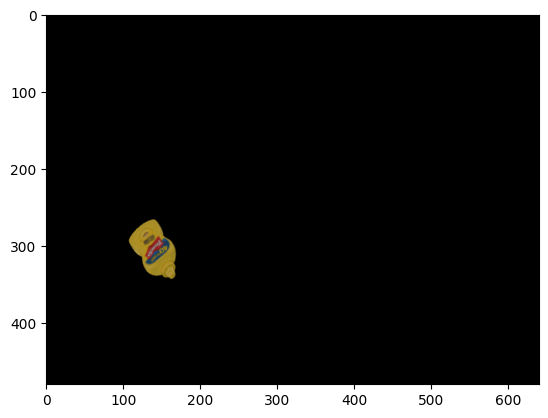

In [3]:
if USE_GT_AS_BASE_POSE:
    base_pose = start_pose
else:
    base_pose = np.eye(4)
    diameter = get_diameter_from_mesh(mesh)
    print(diameter)
    # Rotate 90 degrees around x-axis then rotate around y-axis 180 degrees
    base_pose[:3, :3] = np.array([[1, 0, 0], [0, 0, -1], [0, 1, 0]])
    base_pose[:3, :3] = (
        np.array([[-1, 0, 0], [0, 1, 0], [0, 0, -1]]) @ base_pose[:3, :3]
    )
    base_pose[:3, 3] = np.array([0, 0, diameter])
rgb_render, depth_render = model_renderer.render(mesh, ob_in_cvcam=base_pose)

plt.imshow(rgb_render)
plt.show()

In [4]:
if not os.path.exists(video_mask_dir) or len(os.listdir(video_mask_dir)) == 0:
    segment(video_rgb_dir, video_mask_dir, prompts=[(124, 292), (135, 304), (156, 336)])

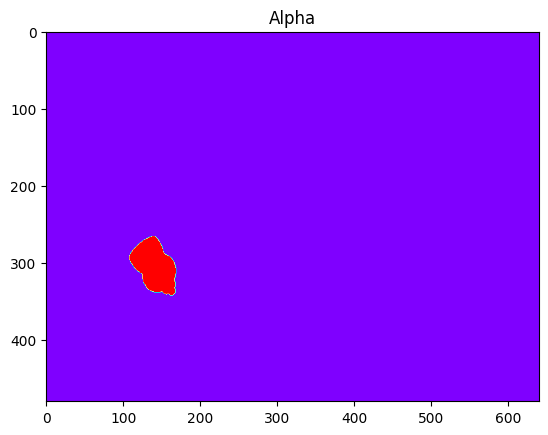

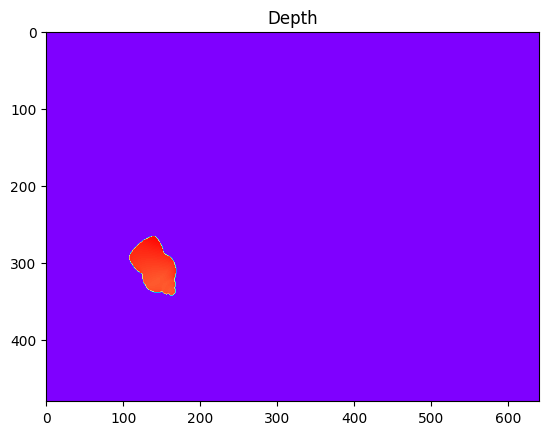

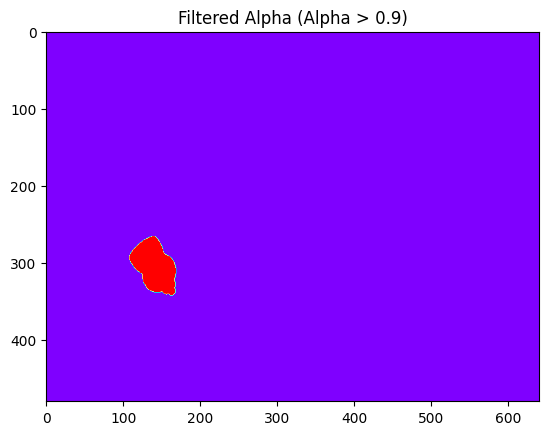

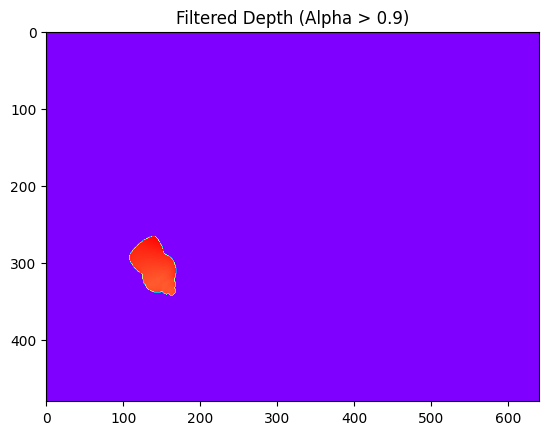

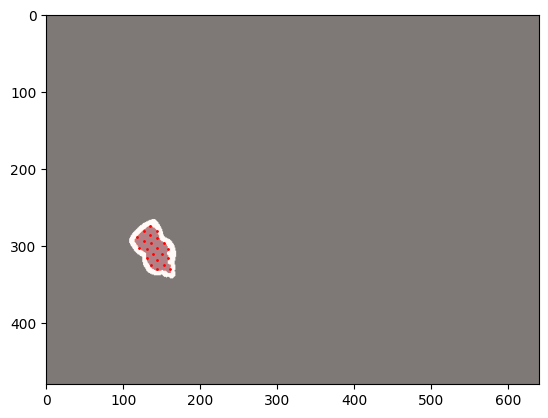

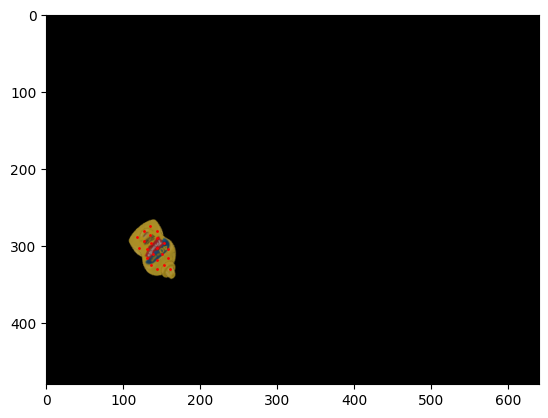

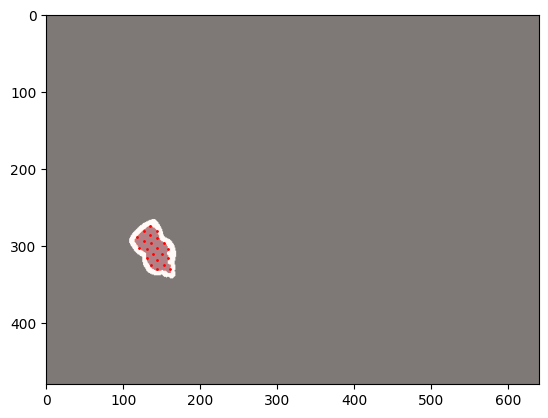

(22, 3)
[[  0.         135.01138327 274.00240865]
 [  0.         126.00742958 280.00957166]
 [  0.         143.01303474 280.00281515]
 [  0.         134.00901857 286.01055763]
 [  0.         118.00066926 288.011713  ]]


In [5]:
def get_bbox(mask):
    # Find indices of True values
    rows, cols = np.where(mask)

    if len(rows) == 0:
        return None  # Return None if mask is empty

    # Get bounding box coordinates
    min_row, max_row = rows.min(), rows.max()
    min_col, max_col = cols.min(), cols.max()

    return (min_col, min_row, max_col, max_row)


def process_image_crop(
    image: np.ndarray, bbox: tuple, padding: int, target_size: tuple
) -> Tuple[np.ndarray, tuple, tuple]:
    """
    Process an image by cropping around a bounding box with padding and resizing to target dimensions.

    Args:
        image: Input image as numpy array (H, W, C)
        bbox: Tuple of (x1, y1, x2, y2) coordinates
        padding: Initial padding amount in pixels
        target_size: Tuple of (target_height, target_width)

    Returns:
        tuple containing:
        - Processed image as numpy array
        - New bounding box coordinates
        - Zoom factor applied
    """
    orig_h, orig_w = image.shape[:2]
    target_h, target_w = target_size
    x1, y1, x2, y2 = bbox

    # Calculate initial crop dimensions with padding
    crop_x1 = max(0, x1 - padding)
    crop_y1 = max(0, y1 - padding)
    crop_x2 = min(orig_w, x2 + padding)
    crop_y2 = min(orig_h, y2 + padding)

    # Crop the image
    cropped = image[crop_y1:crop_y2, crop_x1:crop_x2]

    # Convert cropped image to tensor and add batch and channel dimensions
    cropped_tensor = torch.tensor(cropped.copy()).permute(2, 0, 1).unsqueeze(0).float()

    # Interpolate to target size
    scaled = F.interpolate(
        cropped_tensor, size=target_size, mode="bilinear", align_corners=True
    )

    # Remove batch and channel dimensions
    scaled = scaled.squeeze(0).permute(1, 2, 0)

    # Calculate scaling factors
    scale_x = target_w / (crop_x2 - crop_x1)
    scale_y = target_h / (crop_y2 - crop_y1)

    return (
        scaled.detach().cpu().numpy(),
        (crop_x1, crop_y1, crop_x2, crop_y2),
        (scale_x, scale_y),
    )


def sample_support_grid_points(
    H: int, W: int, query_frame_idx: int, query_mask: np.ndarray, grid_size: int = 10
):
    """
    Generates a grid of sample support points within the given frame dimensions,
    excluding the border and avoiding points inside the query mask.

    Args:
        H (int): Height of the frame.
        W (int): Width of the frame.
        query_frame_idx (int): The frame index to which the points belong.
        query_mask (np.ndarray): A binary mask indicating the regions to avoid.
        grid_size (int, optional): The number of grid points along each dimension.
                                   Defaults to 10.

    Returns:
        np.ndarray: An array of shape (N, 3) where N is the number of valid grid points.
                    Each row contains [query_frame, x, y] coordinates of a grid point.
    """
    grid_size += 2
    x = np.linspace(0, W, grid_size, dtype=int)[1:-1]
    y = np.linspace(0, H, grid_size, dtype=int)[1:-1]
    xx, yy = np.meshgrid(x, y)
    pixels = np.stack([xx.flatten(), yy.flatten()], axis=1)
    # Prevent pixels from being inside the query_mask
    pixels = pixels[query_mask[yy.flatten(), xx.flatten()] == 0]
    return np.concatenate(
        [
            query_frame_idx * np.ones((len(pixels), 1)),
            pixels,
        ],
        axis=1,
    )


first_frame_name = sorted(os.listdir(video_rgb_dir))[0]
first_frame = cv2.cvtColor(
    cv2.imread(os.path.join(video_rgb_dir, first_frame_name)),
    cv2.COLOR_BGR2RGB,
)
first_frame_mask = cv2.imread(
    os.path.join(video_mask_dir, "0.png"), cv2.IMREAD_GRAYSCALE
)

unposed_3d_points, query_2d_points = get_safe_query_points(
    R=base_pose[:3, :3],
    T=base_pose[:3, 3],
    camK=K,
    H=H,
    W=W,
    mesh=mesh,
    debug_vis=True,
    min_pixel_distance=10 if USE_GT_AS_BASE_POSE else 25,
    alpha_margin=5 if USE_GT_AS_BASE_POSE else 15,
    depth_margin=2 if USE_GT_AS_BASE_POSE else 6,
)
num_of_main_queries = len(unposed_3d_points)
# Add support grid
if SUPPORT_GRID is not None:
    support_grid_points = sample_support_grid_points(
        H, W, NUM_INTERPOLATION_STEPS, first_frame_mask, grid_size=SUPPORT_GRID
    )
    query_2d_points = np.concatenate([query_2d_points, support_grid_points], axis=0)

if CROP:
    rgb_render, depth_render = model_renderer.render(mesh, ob_in_cvcam=base_pose)
    bbox = get_bbox(depth_render > 0)
    assert bbox
    rgb_render, processed_bbox, scaling_factor = process_image_crop(
        rgb_render, bbox, padding=10, target_size=COTRACKER_MODEL_RESOLUTION
    )
    depth_render = depth_render[
        processed_bbox[1] : processed_bbox[3], processed_bbox[0] : processed_bbox[2]
    ]
    query_2d_points_scaled = query_2d_points.copy()
    query_2d_points_scaled[:, 1] -= processed_bbox[0]
    query_2d_points_scaled[:, 2] -= processed_bbox[1]
    query_2d_points_scaled[:, 1] *= scaling_factor[0]
    query_2d_points_scaled[:, 2] *= scaling_factor[1]
else:
    query_2d_points_scaled = query_2d_points

# Save unposed_3d_points and query_2d_points as npy files
np.save(canonical_points_path, unposed_3d_points)
np.save(query_points_path, query_2d_points)
print(query_2d_points.shape)
print(query_2d_points[:5, :])

0 254


""

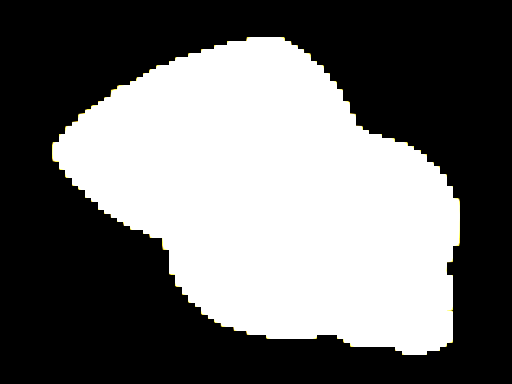

In [6]:
def interpolate_poses(R_start, T_start, R_end, T_end, num_steps):
    """Interpolate between initial (R_start, T_start) and final (R_end, T_end) poses using built-in functions."""
    # Convert rotation matrices to `Rotation` objects
    rot_start = R.from_matrix(R_start)
    rot_end = R.from_matrix(R_end)

    # Generate a series of fractional steps from 0 to 1
    fractions = np.linspace(0, 1, num_steps)

    # Interpolate rotation using built-in SLERP
    slerp = Slerp([0, 1], R.from_quat([rot_start.as_quat(), rot_end.as_quat()]))
    rotations = slerp(fractions)

    # Interpolate translation using LERP
    translations = np.array([T_start + f * (T_end - T_start) for f in fractions])

    # Combine rotations and translations into poses
    interpolated_poses = [
        (rotations[i].as_matrix(), translations[i]) for i in range(num_steps)
    ]

    return interpolated_poses


num_steps = NUM_INTERPOLATION_STEPS
interpolated_poses = (
    interpolate_poses(
        base_pose[:3, :3],
        base_pose[:3, 3],
        start_pose[:3, :3],
        start_pose[:3, 3],
        num_steps,
    )
    if num_steps > 0
    else []
)

# Check that video_img_dir exists, if not create it
if not os.path.exists(video_img_dir):
    os.makedirs(video_img_dir)
# Check that video_img_dir is empty, if not delete its contents
for f in os.listdir(video_img_dir):
    os.remove(os.path.join(video_img_dir, f))
# Copy contents from video_rgb_dir (.png) to video_img_dir (.jpg) in order, but renamed with 5-digit numbers
for i, f in enumerate(sorted(os.listdir(video_rgb_dir))):
    img = cv2.imread(os.path.join(video_rgb_dir, f))
    mask = (
        cv2.imread(os.path.join(video_mask_dir, f"{i}.png"), cv2.IMREAD_GRAYSCALE) / 255
    )
    if BLACK_BACKGROUND:
        img[mask < MASK_THRESHOLD, :] = 0
    if CROP:
        # Find bounding box of mask
        bbox = get_bbox(mask >= MASK_THRESHOLD)
        assert bbox
        img, processed_bbox, scaling_factor = process_image_crop(
            img, bbox, padding=10, target_size=COTRACKER_MODEL_RESOLUTION
        )
    cv2.imwrite(os.path.join(video_img_dir, f"{i + num_steps:05d}.jpg"), img)
print(np.min(first_frame_mask), np.max(first_frame_mask))
first_frame[first_frame_mask > 0, :] = 0
# Print results
frames = []
# subprocess.run(["ffmpeg", "-i", object_video_path, "-q:v", "2", "-start_number", "0", f"{object_video_dir}/img/%05d.jpg"])
for i, (R_i, T_i) in enumerate(interpolated_poses):
    frame_pose = np.eye(4)
    frame_pose[:3, :3] = R_i
    frame_pose[:3, 3] = T_i
    rgb_render, depth_render = model_renderer.render(mesh, ob_in_cvcam=frame_pose)
    if not BLACK_BACKGROUND:
        depth_render_match = depth_render[:, :, None]
        rgb_render = first_frame * (depth_render_match <= 0) + rgb_render * (
            depth_render_match > 0
        )
    if CROP:
        bbox = get_bbox(depth_render > 0)
        assert bbox
        rgb_render, processed_bbox, scaling_factor = process_image_crop(
            rgb_render, bbox, padding=10, target_size=COTRACKER_MODEL_RESOLUTION
        )
        depth_render = depth_render[
            processed_bbox[1] : processed_bbox[3], processed_bbox[0] : processed_bbox[2]
        ]
    if i == 0:
        if CROP:
            query_2d_points_scaled = query_2d_points.copy()
            query_2d_points_scaled[:, 1] -= processed_bbox[0]
            query_2d_points_scaled[:, 2] -= processed_bbox[1]
            query_2d_points_scaled[:, 1] *= scaling_factor[0]
            query_2d_points_scaled[:, 2] *= scaling_factor[1]
        else:
            query_2d_points_scaled = query_2d_points
    frames.append(rgb_render)
    cv2.imwrite(
        os.path.join(video_img_dir, f"{i:05d}.jpg"),
        cv2.cvtColor(rgb_render, cv2.COLOR_RGB2BGR),
    )
mediapy.show_video(
    frames, fps=15
) if NUM_INTERPOLATION_STEPS > 0 else mediapy.show_image(rgb_render)

In [7]:
if NUM_INTERPOLATION_STEPS > 0:
    plt.imshow(frames[0])
    plt.scatter(query_2d_points_scaled[:, 1], query_2d_points_scaled[:, 2], c="r")
    # plt.scatter(query_2d_points[:, 1], query_2d_points[:, 2], c="b")
    print(query_2d_points[:1, :])
    print(query_2d_points_scaled[:1, :])

In [8]:
from posingpixels.cotracker import get_offline_cotracker_predictions


if not OFFLINE:
    pred_tracks, pred_visibility, pred_confidence = get_online_cotracker_predictions(
        video_img_dir,
        grid_size=0,
        queries=query_2d_points_scaled,
    )
if OFFLINE:
    pred_tracks, pred_visibility, pred_confidence = get_offline_cotracker_predictions(
        video_img_dir,
        grid_size=0,
        queries=query_2d_points_scaled,
        limit=OFFLINE_LIMIT,
    )

In [9]:
from posingpixels.datasets import load_video_images


video = load_video_images(video_img_dir, limit=OFFLINE_LIMIT if OFFLINE else None)

In [10]:
tracker_result_video = os.path.join(video_dir)
num_of_main_queries = len(unposed_3d_points)
print(num_of_main_queries, pred_tracks.shape, pred_visibility.shape)
print(video.shape)


def visualize_results(
    video,
    pred_tracks,
    pred_visibility,
    pred_confidence,
    save_dir,
    num_of_main_queries=None,
    filename="video",
):
    if num_of_main_queries is None:
        num_of_main_queries = pred_tracks.shape[2]
    vis = Visualizer(save_dir=save_dir, pad_value=0, linewidth=3)
    vis.visualize(
        video,
        pred_tracks[:, :, :num_of_main_queries, :],
        (pred_visibility * pred_confidence > 0.6)[:, :, :num_of_main_queries],
        filename=filename,
    )


visualize_results(
    video,
    pred_tracks,
    pred_visibility,
    pred_confidence,
    tracker_result_video,
    num_of_main_queries=num_of_main_queries,
)

22 torch.Size([1, 500, 22, 2]) torch.Size([1, 500, 22])
torch.Size([1, 500, 3, 384, 512])
Video saved to /home/joao/Documents/repositories/GSPose/data/inputs/mustard0/video.mp4


In [11]:
# Generate ground truth for the coords location (& visibility)
from typing import Tuple

from posingpixels.utils.geometry import apply_pose_to_points, render_points_in_2d
from tqdm import tqdm


def get_ground_truths(
    R, T, K, H, W, mesh, unposed_3d_points, prob_mask
) -> Tuple[np.ndarray, np.ndarray]:
    model_renderer = ModelRendererOffscreen(K, H, W)
    pose = np.eye(4)
    pose[:3, :3] = R
    pose[:3, 3] = T
    _, depth = model_renderer.render(mesh, ob_in_cvcam=pose)
    posed_3d_points = apply_pose_to_points(unposed_3d_points, R, T)
    gt_coords = render_points_in_2d(posed_3d_points, K[:3, :3])
    # Get the depth values posed_3d_points[:, 2] at the 2D coordinates gt_coords
    gt_depth = depth[gt_coords[:, 1].astype(int), gt_coords[:, 0].astype(int)]
    # Calculate visibility based on depth values
    gt_visibility = (gt_depth - posed_3d_points[:, 2]) > 0.01
    # Apply prob_mask
    gt_visibility = (
        gt_visibility
        * prob_mask[gt_coords[:, 1].astype(int), gt_coords[:, 0].astype(int)]
    )

    return gt_coords, gt_visibility


gt_coords = np.zeros((len(video_files), num_of_main_queries, 2))
gt_visibility = np.zeros((len(video_files), num_of_main_queries))

for i, (R_i, T_i) in enumerate(
    tqdm(interpolated_poses, desc="Processing interpolated poses")
):
    mask = (
        cv2.imread(os.path.join(video_mask_dir, f"{i}.png"), cv2.IMREAD_GRAYSCALE) / 255
    )
    gt_coords[i], gt_visibility[i] = get_ground_truths(
        R_i, T_i, K, H, W, mesh, unposed_3d_points, first_frame_mask
    )

for i in tqdm(
    range(NUM_INTERPOLATION_STEPS, len(video_files)), desc="Processing remaining frames"
):
    mask = (
        cv2.imread(os.path.join(video_mask_dir, f"{i}.png"), cv2.IMREAD_GRAYSCALE) / 255
    )
    pose_path = os.path.join(poses_dir, f"{i - NUM_INTERPOLATION_STEPS:07d}.txt")
    if os.path.exists(pose_path):
        start_pose = np.loadtxt(
            os.path.join(poses_dir, f"{i - NUM_INTERPOLATION_STEPS:07d}.txt")
        ).reshape(4, 4)
    gt_coords[i], gt_visibility[i] = get_ground_truths(
        start_pose[:3, :3], start_pose[:3, 3], K, H, W, mesh, unposed_3d_points, mask
    )

np.save(video_gt_coords_dir, gt_coords)
np.save(video_gt_visibility_dir, gt_visibility)

gt_coords_torch = torch.tensor(gt_coords).to(device)[None]
gt_visibility_torch = torch.tensor(gt_visibility).to(device)[None]
visualize_results(
    video,
    gt_coords_torch,
    gt_visibility_torch,
    torch.ones_like(gt_visibility_torch).to(device)[None],
    tracker_result_video,
    num_of_main_queries=num_of_main_queries,
    filename="gt_video",
)

NameError: name 'video_files' is not defined

In [ ]:
# See distribution of confidence values over time
conf_np = pred_confidence.detach().cpu().numpy()[0]
print(conf_np.shape)
plt.plot(conf_np.mean(axis=1))
plt.axvline(x=NUM_INTERPOLATION_STEPS - 1, color="r", linestyle="--")
plt.title("Mean confidence over time")
plt.show()
plt.plot(conf_np.mean(axis=1)[:20])
# Plot vertical line at NUM_INTERPOLATION_STEPS
plt.axvline(x=NUM_INTERPOLATION_STEPS - 1, color="r", linestyle="--")
plt.title("Mean confidence over time")
plt.show()
# Plot distribution of confidence values at frame NUM_INTERPOLATION_STEPS - 1
plt.hist(conf_np[NUM_INTERPOLATION_STEPS - 1])
plt.title(f"Distribution of confidence values at frame {NUM_INTERPOLATION_STEPS - 1}")
plt.show()
# Plot distribution of confidence values at frame NUM_INTERPOLATION_STEPS + 1
plt.hist(conf_np[NUM_INTERPOLATION_STEPS + 1])
plt.title(f"Distribution of confidence values at frame {NUM_INTERPOLATION_STEPS + 1}")
plt.show()